# Install required libraries

In [1]:
#! pip install pandas==2.1.4 
#! pip install scikit-learn==1.5.2 
#! pip install sentence-transformers==3.1.1 
#! pip install numpy==1.26.4 
#! pip install matplotlib==3.7.1
#! pip install seaborn==0.12.2
#! pip install openpyxl
#! pip install seaborn

# Import Data

In [2]:
import pandas as pd

## Controls and metrics

In [3]:
# Data to associate metrics with controls
metrics = pd.read_csv('TrainAndTestData/testData/metricsAndControls/metrics.csv')
controls = pd.read_csv('TrainAndTestData/testData/metricsAndControls/controls.csv')


## Contols and controls

### Read EUCS

In [4]:
# Data for associating controls with controls
EUCS = pd.read_excel('TrainAndTestData/testData/controlsAndControls/MEDINA_ControlsMapping_Clean.xlsx', header=1)
EUCS = EUCS.drop(['Code', 'SecNumCloud FRANCE ', 'ISO 27002 ', 'ISO 27017 ', 'EUCS Category'], axis=1)

# Extract Id from control description
EUCS['controlId'] = EUCS['EUCS Control (2022)'].str.extract(r'^(\S+)')

# Remove the extracted text (controlId) from the "EUCS Control (2022)" column
EUCS['EUCS Control (2022)'] = EUCS['EUCS Control (2022)'].str.replace(r'^\S+\s*', '', regex=True)

# Rename the column "EUCS Control (2022)" to "description"
EUCS.rename(columns={'EUCS Control (2022)': 'description'}, inplace=True)

# Removing rows with no id
EUCS = EUCS.dropna(subset=['controlId'])

# Remove the leading '- ' from the "description" column
EUCS['description'] = EUCS['description'].str.replace(r'^- ', '', regex=True)

# Remove the last row of the DataFrame wich is not useful
EUCS = EUCS.iloc[:-1]

# Extract the values of the column 'C5.2020 GERMANY' into a list
# Add the cleaned list back into the DataFrame as a new column
EUCS['BSIC5'] = (
    EUCS['C5.2020 GERMANY ']
    .dropna()
    .str.split('\n')
    .apply(lambda x: [item.strip() for item in x])  # Clean up extra spaces
)

# Remove old column for ids
EUCS = EUCS.drop(['C5.2020 GERMANY '], axis=1)

# Removing rows with no description
EUCS = EUCS.dropna(subset=['BSIC5'])

EUCS

,description,controlId,BSIC5
0,INFORMATION SECURITY MANAGEMENT SYSTEM,OIS-01,[OIS-01]
1,SEGREGATION OF DUTIES,OIS-02,[OIS-04]
2,CONTACT WITH AUTHORITIES AND INTEREST GROUPS,OIS-03,[OIS-05]
3,INFORMATION SECURITY IN PROJECT MANAGEMENT,OIS-04,"[OIS-05, OIS-06, OIS-07]"
4,GLOBAL INFORMATION SECURITY POLICY,ISP-01,[OIS-02]
...,...,...,...
115,ERROR HANDLING AND LOGGING MECHANISMS,PSS-01,[PSS-04]
116,SESSION MANAGEMENT,PSS-02,[PSS-06]
117,SOFTWARE DEFINED NETWORKING,PSS-03,[PSS-10]
118,IMAGES FOR VIRTUAL MACHINES AND CONTAINERS,PSS-04,[PSS-11]


### BSIC5

In [5]:
# Data for associating controls with controls
BSIC5 = pd.read_excel('TrainAndTestData/testData/controlsAndControls/C5_2020_editable.xlsx', sheet_name="C5-2020 Criteria")
#BSIC5 = BSIC5.drop(['Title', 'SecNumCloud FRANCE ', 'ISO 27002 ', 'ISO 27017 ', 'EUCS Category'], axis=1)
BSIC5 = BSIC5[['ID', 'Basic Criteria']]

# Rimuovere gli spazi in eccesso negli ID
BSIC5['ID'] = BSIC5['ID'].str.strip()
EUCS['controlId'] = EUCS['controlId'].str.strip()

# Aggiungere la colonna con le associazioni
def get_associations(row, df2):
    # Trova tutte le righe di df2 in cui controlId corrisponde all'ID
    associated_ids = df2[df2['BSIC5'].apply(lambda x: row['ID'] in x)]['controlId'].tolist()
    return associated_ids

# Applicare la funzione per aggiungere la colonna 'Associations'
BSIC5['Associations'] = BSIC5.apply(get_associations, axis=1, df2=EUCS)
BSIC5 = BSIC5.explode("Associations")


BSIC5 = BSIC5.dropna(subset=['Associations'])


BSIC5.rename(columns={'Basic Criteria': 'description', 'Associations': 'controlId'}, inplace=True)


# Resetting index for controlOrigin
EUCS.reset_index(drop=True, inplace=True)

# Resetting index for controlAssociated
BSIC5.reset_index(drop=True, inplace=True)


BSIC5

,ID,description,controlId
0,OIS-01,The Cloud Service Provider operates an informa...,OIS-01
1,OIS-02,The top management of the Cloud Service Provid...,ISP-01
2,OIS-04,Conflicting tasks and responsibilities are sep...,OIS-02
3,OIS-05,The Cloud Service Provider leverages relevant ...,OIS-03
4,OIS-05,The Cloud Service Provider leverages relevant ...,OIS-04
...,...,...,...
119,PSS-06,"To protect confidentiality, availability, inte...",PSS-02
120,PSS-10,If the Cloud Service offers functions for soft...,CS-07
121,PSS-10,If the Cloud Service offers functions for soft...,PSS-03
122,PSS-11,If cloud customers operate virtual machines or...,PSS-04


# Define function to get performance form all the models

[Sbert best models of July 2024](:https://web.archive.org/web/20240713204208/https://www.sbert.net/docs/sentence_transformer/pretrained_models.html)

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import seaborn as sns
import pandas as pd
import os

def evaluate_and_generate_full_dataset(model_names, Controls, Metrics, outputFileName, model_shortnames, baseline=True):
    results = []

    for model_name in model_names:
        print(f"Valutazione modello: {model_name}...")
        
        # Load the model and compute embeddings
        # SentenceTransformer caricherà automaticamente da locale se 'model_name' è un percorso valido
        try:
            model = SentenceTransformer(model_name, trust_remote_code=True)
        except Exception as e:
            print(f"Errore nel caricamento di {model_name}: {e}")
            continue

        # Encoding
        controls_embeddings = model.encode(Controls['description'].tolist(), convert_to_tensor=True).cpu()
        metrics_embeddings = model.encode(Metrics['description'].tolist(), convert_to_tensor=True).cpu()

        for i, con_row in Controls.iterrows():
            con_id = con_row['controlId']
            con_embedding = controls_embeddings[i]

            # Ground truth associated metrics (IDs)
            associated_metrics_ids = Metrics[Metrics['controlId'] == con_id]['ID'].tolist()

            # Compute similarity scores
            similarity_scores = cosine_similarity(con_embedding.reshape(1, -1), metrics_embeddings).flatten()
            sorted_indices = np.argsort(similarity_scores)[::-1]
            model_predicted_metrics_ids = Metrics.iloc[sorted_indices]['ID'].tolist()

            # Remove duplicates preserving order
            seen = set()
            model_predicted_metrics_ids_unique = []
            for metric_id in model_predicted_metrics_ids:
                if metric_id not in seen:
                    model_predicted_metrics_ids_unique.append(metric_id)
                    seen.add(metric_id)
            
            model_predicted_metrics_ids = model_predicted_metrics_ids_unique

            # Calculate nDCG
            if len(associated_metrics_ids) > 0:
                ground_truth_scores = [1 if metric_id in associated_metrics_ids else 0 for metric_id in Metrics['ID']]
                model_scores = similarity_scores.reshape(1, -1)
                ndcg = ndcg_score([ground_truth_scores], model_scores, k=min(10, len(model_scores.flatten())))
            else:
                ndcg = None

            ndcg_nonzero = ndcg if ndcg is not None and ndcg > 0 else None

            results.append({
                'controlId': con_id,
                'model': model_name,
                'nDCG': ndcg,
                'nDCG_nonZero': ndcg_nonzero,
                'ground_truth_ids': associated_metrics_ids,
                'predicted_ids': model_predicted_metrics_ids
            })

    # Create DataFrame
    results_df = pd.DataFrame(results)

    # Compute means
    mean_nDCG_results = results_df.groupby('model')['nDCG'].mean().dropna().to_dict()
    mean_nDCG_nonZeroes_results = results_df.groupby('model')['nDCG_nonZero'].mean().dropna().to_dict()

    # Plot
    plot_performance(mean_nDCG_results, mean_nDCG_nonZeroes_results, model_shortnames, baseline)

    return results_df.to_csv(outputFileName, index=False)


def plot_performance(mean_nDCG_results, mean_nDCG_nonZeroes_results, model_shortnames, baseline=True):
    baseline_nDCG = 0.275
    baseline_nDCG_nonZero = 0.494
    plt.rcParams.update({'font.size': 14, 'font.family': 'sans-serif'}) # Ho ridotto un po' il font per leggibilità

    # Usa .get() per evitare crash se il modello non è nel dizionario
    models_labels = [model_shortnames.get(model, model) for model in mean_nDCG_results.keys()]
    
    mean_nDCG_values = list(mean_nDCG_results.values())
    mean_nDCG_nonZero_values = list(mean_nDCG_nonZeroes_results.values())

    bar_width = 0.7
    edge_linewidth = 1.5

    # Plot 1: Mean nDCG
    plt.figure(figsize=(12, 8))
    plt.bar(models_labels, mean_nDCG_values, color='steelblue', edgecolor='black', linewidth=edge_linewidth, width=bar_width)
    if baseline:
        plt.axhline(y=baseline_nDCG, color='red', linestyle='--', label=f'Baseline: {baseline_nDCG}', linewidth=2) 
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylabel('Mean nDCG Score')
    plt.title('Comparison of Embeddings Models (nDCG)')
    plt.xticks(rotation=45, ha="right")

    for i, v in enumerate(mean_nDCG_values):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=12)

    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: Mean nDCG (Non-Zero)
    plt.figure(figsize=(12, 8))
    plt.bar(models_labels, mean_nDCG_nonZero_values, color='darkorange', edgecolor='black', linewidth=edge_linewidth, width=bar_width)
    if baseline:
       plt.axhline(y=baseline_nDCG_nonZero, color='red', linestyle='--', label=f'Baseline: {baseline_nDCG_nonZero}', linewidth=2)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylabel('Mean nDCG Score (Non Zero Values)')
    plt.title('Comparison of Embeddings Models (nDCG Non-Zero)')
    plt.xticks(rotation=45, ha="right")

    for i, v in enumerate(mean_nDCG_nonZero_values):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=12)

    plt.legend()
    plt.tight_layout()
    plt.show()

/home/fabio.pinelli/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Association between controls and metrics

In [7]:
my_finetuned_path = 'FineTunedModel/fine_tuned_compliance_model' 

# 2. Lista dei modelli da testare
model_names = [
    'all-mpnet-base-v2', 
    'multi-qa-mpnet-base-dot-v1', 
    'all-distilroberta-v1', 
    'all-MiniLM-L12-v2', 
    'multi-qa-distilbert-cos-v1',
    my_finetuned_path  
]

# 3. Dizionario dei nomi brevi per il grafico
model_shortnames = {
    'all-mpnet-base-v2': 'AMPNet',
    'multi-qa-mpnet-base-dot-v1': 'MMPNet',
    'all-distilroberta-v1': 'DRoBERTa',
    'all-MiniLM-L12-v2': 'MiniLM-L12',
    'multi-qa-distilbert-cos-v1': 'DBERT',
    my_finetuned_path: 'FT-MiniLM-L12' 
}

Valutazione modello: all-mpnet-base-v2...


2025-11-25 15:36:17.030006: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-25 15:36:17.046521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764084977.064975 2928857 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764084977.070666 2928857 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764084977.085695 2928857 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Valutazione modello: multi-qa-mpnet-base-dot-v1...


You try to use a model that was created with version 3.0.0.dev0, however, your version is 2.3.1. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





Valutazione modello: all-distilroberta-v1...


/home/fabio.pinelli/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1520: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Valutazione modello: all-MiniLM-L12-v2...


/home/fabio.pinelli/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1520: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Valutazione modello: multi-qa-distilbert-cos-v1...
Valutazione modello: FineTunedModel/fine_tuned_compliance_model...


/home/fabio.pinelli/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1520: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


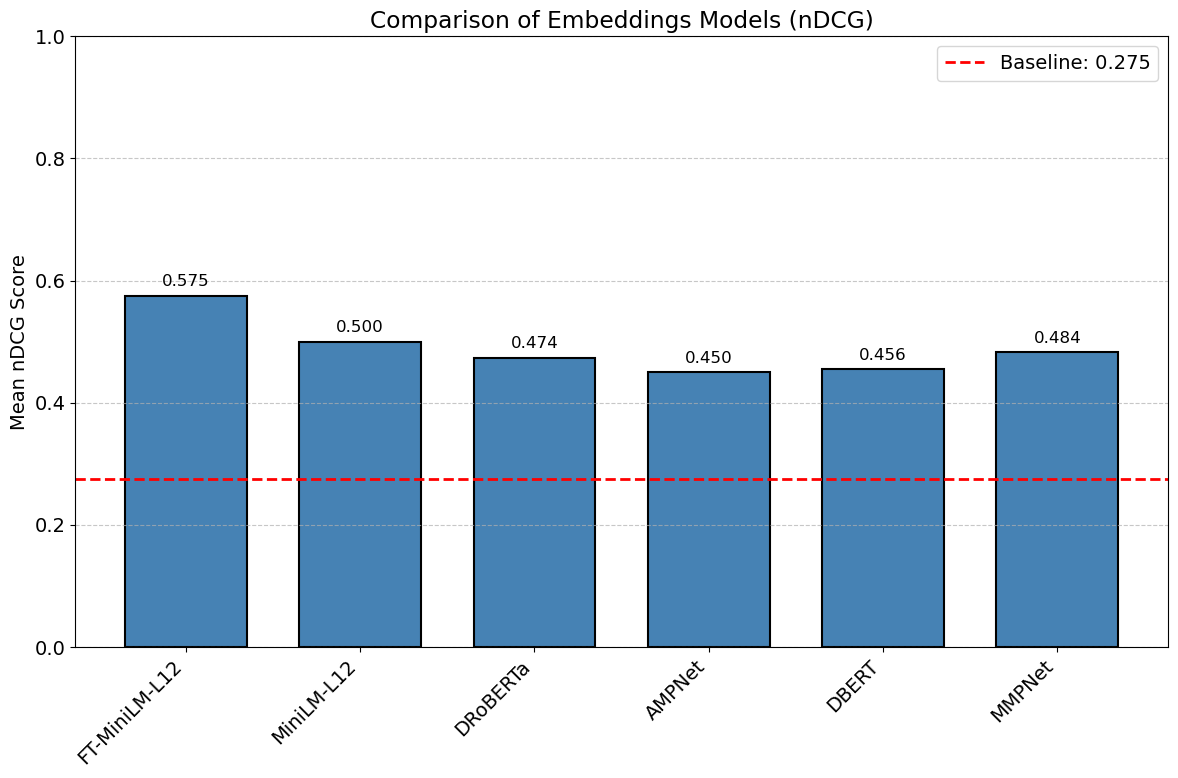

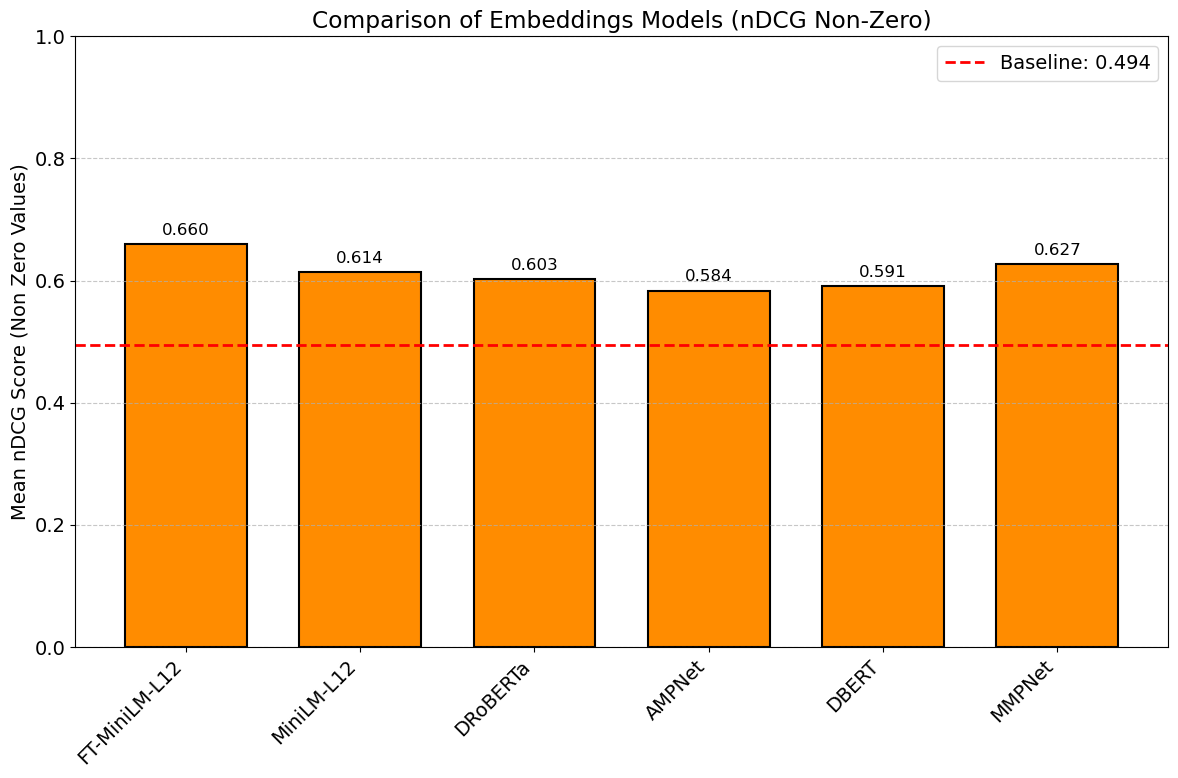

In [8]:
evaluate_and_generate_full_dataset(model_names, controls, metrics,'Results/resultsControlsAndMetricsForAllModels.csv', model_shortnames)


# Associations between controls and controls


Valutazione modello: all-mpnet-base-v2...
Valutazione modello: multi-qa-mpnet-base-dot-v1...


You try to use a model that was created with version 3.0.0.dev0, however, your version is 2.3.1. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





Valutazione modello: all-distilroberta-v1...


/home/fabio.pinelli/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1520: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Valutazione modello: all-MiniLM-L12-v2...


/home/fabio.pinelli/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1520: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Valutazione modello: multi-qa-distilbert-cos-v1...
Valutazione modello: FineTunedModel/fine_tuned_compliance_model...


/home/fabio.pinelli/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1520: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


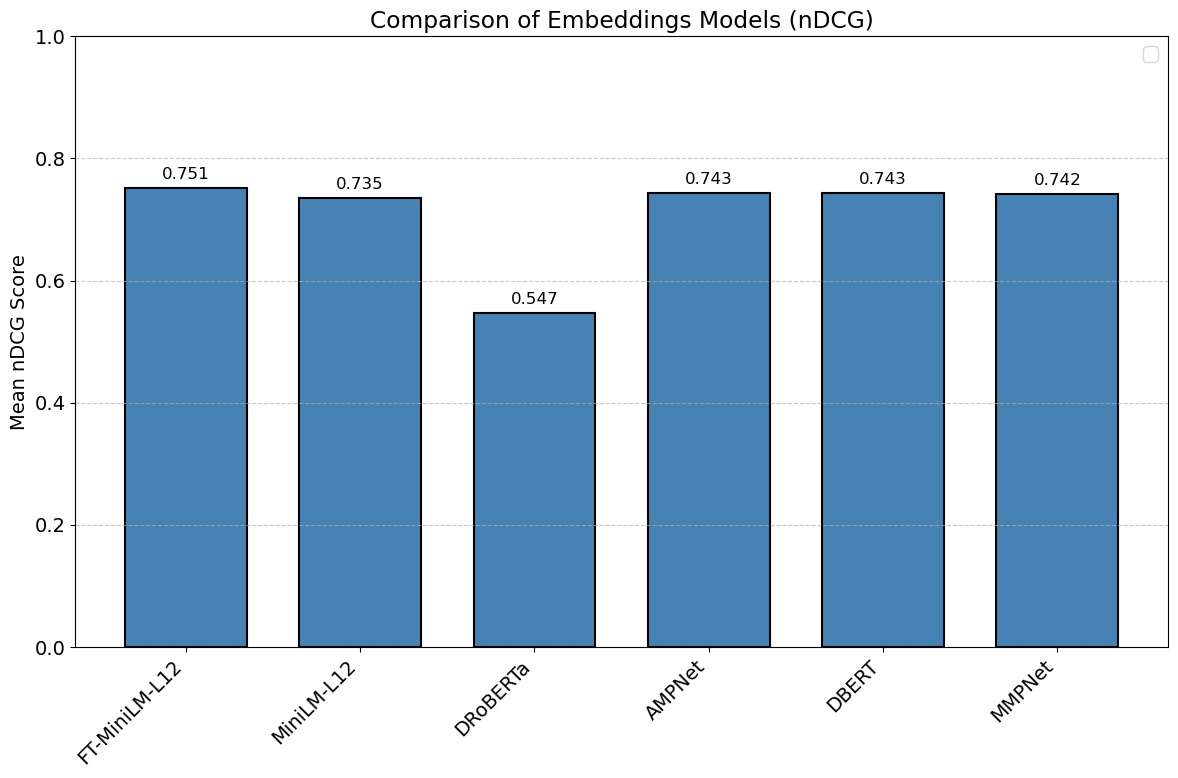

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


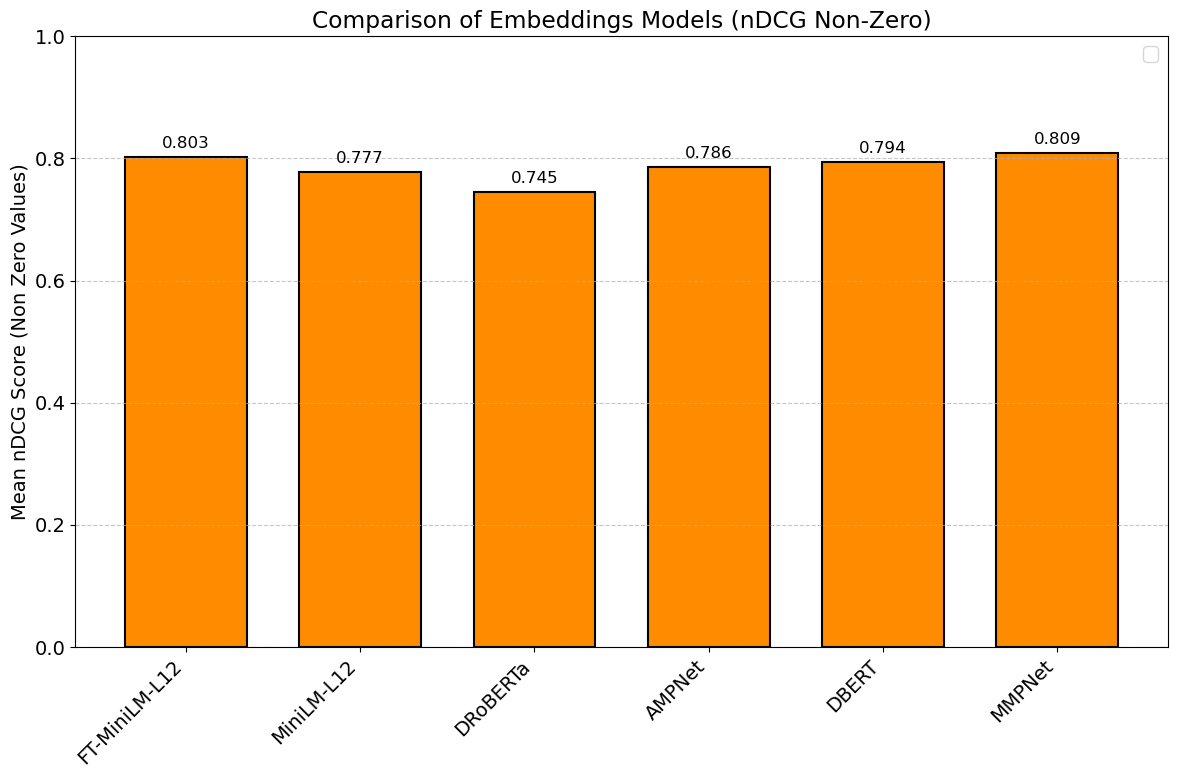

In [11]:
evaluate_and_generate_full_dataset(model_names, EUCS, BSIC5, 'Results/resultsControlsAndControlsForAllModels.csv', model_shortnames, baseline=False)